In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from time import sleep

In [2]:
def diff(p, dim):
    if dim==0:
        p_xdiff = p[1:,:,:] - p[:-1,:,:]
        return torch.cat((p_xdiff, p_xdiff[-2:-1,:,:]))
    elif dim==1:
        p_ydiff = p[:,1:,:] - p[:,:-1,:]
        return torch.cat((p_ydiff, p_ydiff[:,-2:-1,:]), dim=1)
    else:
        raise ValueError('Diff dimension should by either 0 or 1.')



def interpolate2d(coords, values, targets):
    Nx, Ny, Ndim = coords.shape
    Mx, My, Mdim = targets.shape
    
    # Reshape input coordinates & values, and truncate edges
    A  = coords[:-1, :-1, :].view(1, 1, Nx-1, Ny-1, Ndim)
    B  = coords[ 1:, :-1, :].view(1, 1, Nx-1, Ny-1, Ndim)
    C  = coords[:-1,  1:, :].view(1, 1, Nx-1, Ny-1, Ndim)
    D  = coords[ 1:,  1:, :].view(1, 1, Nx-1, Ny-1, Ndim)
    
    VA = values[:-1, :-1   ].view(1, 1, Nx-1, Ny-1)
    VB = values[ 1:, :-1   ].view(1, 1, Nx-1, Ny-1)
    VC = values[:-1,  1:   ].view(1, 1, Nx-1, Ny-1)
    VD = values[ 1:,  1:   ].view(1, 1, Nx-1, Ny-1)

    
    # Reshape target coordinates
    Tx = targets[:,:,0].view(Mx, My, 1, 1)
    Ty = targets[:,:,1].view(Mx, My, 1, 1)
    
    # Compute difference vectors
    AB = B - A
    AC = C - A
    DB = B - D
    DC = C - D
    
    # Seperate x- and y-variables for brevity
    Ax  =  A[:, :, :, :, 0]
    Ay  =  A[:, :, :, :, 1]
    Dx  =  D[:, :, :, :, 0]
    Dy  =  D[:, :, :, :, 1]
    
    ABx =  AB[:, :, :, :, 0]
    ABy =  AB[:, :, :, :, 1]
    ACx =  AC[:, :, :, :, 0]
    ACy =  AC[:, :, :, :, 1]
    DBx =  DB[:, :, :, :, 0]
    DBy =  DB[:, :, :, :, 1]
    DCx =  DC[:, :, :, :, 0]
    DCy =  DC[:, :, :, :, 1]

    
    # Compute coefficients
    denom_A = ABx*ACy - ABy*ACx
    b_A = ((Tx - Ax)*ACy + (Ay-Ty)*ACx) / denom_A
    c_A = ((Ax - Tx)*ABy  + (Ty-Ay)*ABx)  / denom_A
    
    denom_D = DBx*DCy - DBy*DCx
    b_D = ((Tx - Dx)*DCy + (Dy-Ty)*DCx) / denom_D
    c_D = ((Dx - Tx)*DBy  + (Ty-Dy)*DBx)  / denom_D
    
    # Mask coefficients to limit to corresponding triangles
    # Note: Each triangle ABC or DBC only corresponds with a small number of
    # target samples that lie inside that triangle. The rest of the target
    # samples is ignored by that trianlge through masking. Furthermore,
    # in order to correctly count the edges, the A- and D-masks are slightly
    # different: A uses ≥ & ≤, while D uses >. Lastly, bc_A is used both for
    # the A- and D-masks, to prevent rounding errors causing excluding or
    # counting points in both masks. Some rounding errors can still occur
    # for two nearby A- or D-triangles, though these should be virtually
    # nonexistent in practice.
    bc_A = b_A+c_A
    bc_D = b_D+c_D   ######
    mask_A = torch.logical_and(torch.logical_and(b_A>=0, c_A>=0), bc_A<=1)
    mask_D = torch.logical_and(torch.logical_and(b_D>0, c_D>0), bc_D<1)
    
    # Compute interpolated values
    interp_values = torch.sum(mask_A * (VA + (VB-VA)*b_A + (VC-VA)*c_A), (2,3))\
                  + torch.sum(mask_D * (VD + (VB-VD)*b_D + (VC-VD)*c_D), (2,3))
    
    return interp_values

In [3]:
def unit(v):
    """Unit vectors for NxMx3 tensors."""
    normv = torch.norm(v, dim=2, keepdim=True)
    return v / normv


def inner(v, w):
    """Vector inner product for NxMx3 tensors."""
    return torch.sum(v*w, dim=2, keepdim=True)

    
def projection(v, w):
    """Vector projections of vector v onto vector w for NxMx3 tensors."""
    wunit = unit(w)
    return inner(v, wunit) * wunit


def rejection(v, w):
    """Vector rejections of vector v onto vector w for NxMx3 tensors."""
    return v - projection(v, w)


def snellsvec(k_in, N, n_in=1, n_out=1):
    """
    Compute direction vectors of refracted ray for NxMx3 tensors.

    Input:
    k_in    Directional unit vector incoming ray
    N       Surface normal unit vector
    n_in    Refractive index incoming ray
    n_out   Refractive index outgoing ray

    Output:
    k_out   Directional unit vector outgoing ray
    """
    k_inrej = rejection(-k_in, N)       # Perpendicular component k_in
    k_outrej = -n_in/n_out * k_inrej    # Perpendicular component k_out
    k_out = k_outrej - N * torch.sqrt(1 - inner(k_outrej, k_outrej))

    return k_out


def propagate2surf3D(A, k, Csphere, Rsphere, Rring):
    """
    Propagate light ray along z-axis to surface perpendicular to z.

    Input:
    A       Starting position of ray. (x,y,z).
    k       Directional unit vector of ray. (kx, ky, kz). Must have nonzero
            z-component.
    z       Position of surface on z axis. (scalar).
    Rsphere Radius of spherical surface. If Rsphere=0, a flat surface will be
            used. (scalar).
    Rring   Radius indicating the size of the lens. Rays outside this radius
            shall not pass! (scalar).

    Output:
    B       Arrival position of ray at surface. (x,y,z)
    N       Surface normal unit vector. (Nx, Ny, Nz).
    """
#     zdist = z - A                   # Compute relative distance to front

    if Rsphere == 0:                # Flat surface
#         B = A + k * zdist/k[:,:,2]  # Scale k to flat surface
#         N = torch.tensor((0, 0, -1)).view(1,1,3) # Surface normal of flat surface
        pass

    else:                           # Spherical surface
        # See: https://en.wikipedia.org/wiki/Line%E2%80%93sphere_intersection
        # Compute intermediate terms
#         Csphere = torch.tensor((0, 0, z)).view(1,1,3)  # Sphere center
        ACsphere = A - Csphere                          # Center relative to A
        kinACsphere = inner(k, ACsphere)                # Inner product k,ACsph

        # Compute solutions to line-sphere intersection
        discriminant = torch.sqrt(kinACsphere*kinACsphere - inner(ACsphere, ACsphere)
                               + Rsphere*Rsphere)       # Discriminant of ABC equation
        kdist1 = -kinACsphere + discriminant
        kdist2 = -kinACsphere - discriminant
        #####
#         ksort = torch.sort((kdist1, kdist2))

#         if discriminant <= 0:                           # No solutions
#             print('Warning: rays out of bounds!')
#             return

        # Solutions must be forward
        
#         if ksort[0] > 0:
#             kdist = ksort[0]
#         elif ksort[1] > 0:
#             kdist = ksort[1]
#         else:
#             print('Warning: no intersection found in forward ray direction!')
        
#         kmask_less = (kdist1 < kdist2)
#         kmask1 = torch.logical_and(kdist1>0, kmask_less)
#         kmask2 = torch.logical_and(kdist2>0, torch.logical_not(kmask_less))
#         kdist = kdist1*kmask1 + kdist2*kmask2

        eps = 10 * torch.finfo(torch.float32).eps       ##### Machine epsilon for float32, pick larger value due to multiple operations
        k_1eps = (kdist1 > eps)
        k_2eps = (kdist2 > eps)
        k_1l2  = (kdist1 < kdist2)
        
        kmask1 = torch.logical_and(k_1eps, torch.logical_or(torch.logical_not(k_2eps), k_1l2))
        kmask2 = torch.logical_and(k_2eps, torch.logical_or(torch.logical_not(k_1eps), torch.logical_not(k_1l2)))
        kdist  = kdist1*kmask1 + kdist2*kmask2
    
        #####
#         plt.imshow(kdist.detach().squeeze())
#         plt.title('kdist')
#         plt.colorbar()
#         plt.show()
        #####
        
        B = A + k * kdist                               # Solution for intersec
        N = unit(B - Csphere) * torch.sign(torch.tensor(Rsphere))     # Compute normal vector

    return B, N

In [4]:
def RayTransfer(A, B, C, D, p_in, k_in):
    ##### Note! This only works for meridional rays (no tangential component)
    
    ##### tan(theta) instead of sin(theta) !
    pr_in = torch.sqrt(p_in[:,:,0]*p_in[:,:,0] + p_in[:,:,1]*p_in[:,:,1])
    kr_in = torch.sqrt(k_in[:,:,0]*k_in[:,:,0] + k_in[:,:,1]*k_in[:,:,1]) / k_in[:,:,2]
    pr_out = A*pr_in + B*kr_in
    kr_out = (C*pr_in + D*kr_in)
    
    ##### Be wary of divide by 0 errors! Rewrite?
    px_out = p_in[:,:,0] * pr_out / pr_in
    py_out = p_in[:,:,1] * pr_out / pr_in
    kx_out = k_in[:,:,0] * kr_out / kr_in
    ky_out = k_in[:,:,1] * kr_out / kr_in
    
    ##### Add z distance
    p_out = torch.stack((px_out, py_out, p_in[:,:,2]), 2)
    k_out = torch.stack((kx_out, ky_out, k_in[:,:,2]), 2)
    
    return p_out, k_out

In [5]:
p_in = torch.tensor((2,1,0), dtype=torch.float32).view(1,1,3)
k_in = torch.tensor((2,1,0.5), dtype=torch.float32).view(1,1,3)

RayTransfer(1,0,0,1, p_in, k_in)

(tensor([[[2., 1., 0.]]]), tensor([[[2.0000, 1.0000, 0.5000]]]))

In [6]:
def plotresult(interp_intensities_attached, stuff_attached):
    interp_intensities = interp_intensities_attached.detach()
    intensities_attached, pscreen_attached, targets_attached, Nx, Ny, Nx_screen, Ny_screen = stuff_attached
    intensities = intensities_attached.detach()
    pscreen = pscreen_attached.detach()
    targets = targets_attached.detach()

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
    fig.dpi = 80
    xc = pscreen.view(Nx*Ny, 3)[:, 0]
    yc = pscreen.view(Nx*Ny, 3)[:, 1]
    xt = targets.view(Nx_screen*Ny_screen, 2)[:, 0]
    yt = targets.view(Nx_screen*Ny_screen, 2)[:, 1]
    scat = ax1.scatter(xc, yc, s=8, c=intensities.detach(), label='Rays', vmin=0)
    plt.colorbar(scat, ax=ax1)
    ax1.plot(xt, yt, '.w', markersize=0.8, label='Output image')
    ax1.axis('equal')
    ax1.set_facecolor('black')
    legend = ax1.legend(loc=2, facecolor='#444444')
    for text in legend.get_texts():
        text.set_color("white")
    ax1.set_title('Ray positions and intensities on screen')

    plt.imshow(interp_intensities.T, vmin=0)
    plt.gca().invert_yaxis()
    plt.colorbar(ax=ax2)
    ax2.set_title('Output image (normalized)')

    plt.show()

In [7]:
# Test for snellsvec
kx = torch.tensor(((0,0),(0,0)), dtype=torch.float32)
ky = torch.tensor(((0,0),(1,1)), dtype=torch.float32)
kz = torch.tensor(((1,1),(1,1)), dtype=torch.float32)
k  = unit(torch.stack((kx,ky,kz), 2))

Nx = torch.tensor(((0,0), (0,0)), dtype=torch.float32)
Ny = torch.tensor(((0,-1),(0,-1)), dtype=torch.float32)
Nz = torch.tensor(((-1,-1),(-1,-1)), dtype=torch.float32)
N  = unit(torch.stack((Nx,Ny,Nz), 2))

n1 = 1
n2 = 1.5

k_out = snellsvec(k, N, n1, n2)
k_out

tensor([[[0.0000, 0.0000, 1.0000],
         [0.0000, 0.2903, 0.9569]],

        [[0.0000, 0.4714, 0.8819],
         [0.0000, 0.7071, 0.7071]]])

In [8]:
import numpy as np
theta1=np.pi/4
print(f'{np.arcsin(n1/n2 * np.sin(theta1))}')
print(np.pi/4 - np.arctan(k_out[0,1,1]/k_out[0,1,2]).item())
print(np.arctan(k_out[1,0,1]/k_out[1,0,2]).item())

0.4908826782893113
0.4908827026678493
0.49088266491889954


In [9]:
help(propagate2surf3D)

Help on function propagate2surf3D in module __main__:

propagate2surf3D(A, k, Csphere, Rsphere, Rring)
    Propagate light ray along z-axis to surface perpendicular to z.
    
    Input:
    A       Starting position of ray. (x,y,z).
    k       Directional unit vector of ray. (kx, ky, kz). Must have nonzero
            z-component.
    z       Position of surface on z axis. (scalar).
    Rsphere Radius of spherical surface. If Rsphere=0, a flat surface will be
            used. (scalar).
    Rring   Radius indicating the size of the lens. Rays outside this radius
            shall not pass! (scalar).
    
    Output:
    B       Arrival position of ray at surface. (x,y,z)
    N       Surface normal unit vector. (Nx, Ny, Nz).



In [10]:
help(snellsvec)

Help on function snellsvec in module __main__:

snellsvec(k_in, N, n_in=1, n_out=1)
    Compute direction vectors of refracted ray for NxMx3 tensors.
    
    Input:
    k_in    Directional unit vector incoming ray
    N       Surface normal unit vector
    n_in    Refractive index incoming ray
    n_out   Refractive index outgoing ray
    
    Output:
    k_out   Directional unit vector outgoing ray



Initial guess: ABCD = 1.000, 0.000, 0.000, 1.000


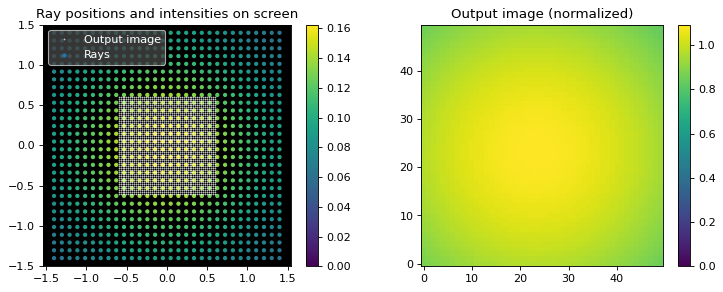

Iteration 0. Loss: 41.5
Iteration 5. Loss: 27
Iteration 10. Loss: 2.99
Iteration 15. Loss: 2.94e-07
Iteration 19. Loss: 0

Predicted: ABCD = 1.000, 0.000, -1.000, 1.000


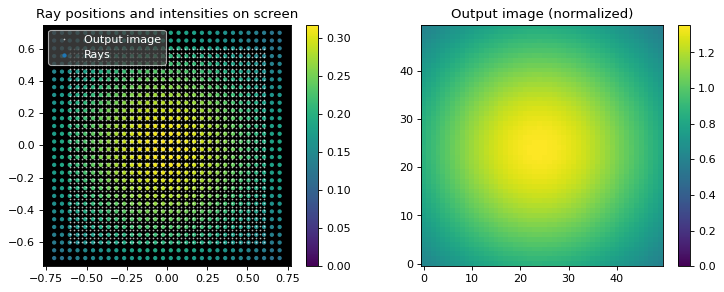

Ground truth: ABCD = 1.000, 0.000, -1.000, 1.000


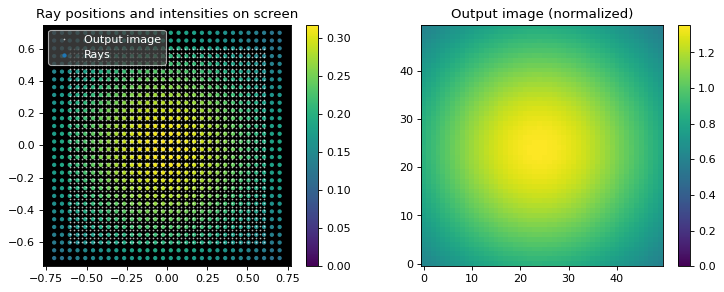

In [11]:
class RayLearner(nn.Module):
    def __init__(self, p0, p_sphere, A, B, C, D):
        super(RayLearner, self).__init__()
#         self.p0 = nn.Parameter(p0, requires_grad=True)
        self.p0 = p0
        self.p_sphere = p_sphere
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        
    def forward(self):
        A = self.A
        B = self.B
        C = self.C
        D = self.D
        
        # Point source
        Nx = 30
        Ny = 30

        p0 = self.p0
        s0x, s0y = torch.meshgrid(torch.linspace(-0.701,0.7,Nx), torch.linspace(-0.7,0.7,Ny))
        s0z = torch.ones(Ny,Nx)#*torch.linspace(1,1,Nx)
        s0 = unit(torch.stack((s0x, s0y, s0z), 2))
        
        # Propagate through sphere
#         sphere_center = torch.tensor((0,0,3)).view(1,1,3)
        n_sphere = 1.5
        Rsphere = 2
        p_sphere = self.p_sphere
#         B_insphere, N_insphere = propagate2surf3D(p0, s0, p_sphere, Rsphere, 2)
#         s_insphere = snellsvec(s0, N_insphere, 1, n_sphere)
#         B_outsphere, N_outsphere = propagate2surf3D(B_insphere, s_insphere, p_sphere, Rsphere, 2)
#         s_outsphere = snellsvec(s_insphere, -N_outsphere, n_sphere, 1)

        # ABCD plane
        ABCDpoint = torch.tensor((0,0,1)).view(1,1,3)
        ABCDnorm  = torch.tensor((0,0,-1)).view(1,1,3)

        # Compute ray intersections with screen ####
        d = inner((ABCDpoint - p0), (ABCDnorm)) / inner(s0, ABCDnorm)
        p2 = p0 + s0*d

        p3, s3 = RayTransfer(A, B, C, D, p2, s0)
        
        # CCD plane
        screenpoint = torch.tensor((0,0,2)).view(1,1,3)
        screennorm  = torch.tensor((0,0,-1)).view(1,1,3)

        # Compute ray intersections with screen ####
        d = inner((screenpoint - p3), (screennorm)) / inner(s3, screennorm)
        pscreen = p3 + s3*d

        ### Compute screen coordinates

        # Approximate ray density by computing cross product
        p1_xdiff = diff(s0, 0)
        p1_ydiff = diff(s0, 1)
        p1_areas = torch.abs(p1_xdiff.cross(p1_ydiff).norm(dim=2))

        pscreen_xdiff = diff(pscreen, 0)
        pscreen_ydiff = diff(pscreen, 1)
        pscreen_areas = torch.abs(pscreen_xdiff.cross(pscreen_ydiff).norm(dim=2))

        s_norm = s0.norm(dim=2)
        intensities = (1 / (s_norm*s_norm)) * (p1_areas / (pscreen_areas+0.005))  ######

        # Interpolated resampling to image
        ### Assume screen normal=-z for now
        coords = pscreen[:,:,0:2]
        Nx_screen = 50
        Ny_screen = 50
        targets = torch.stack(torch.meshgrid(\
                torch.linspace(-0.6,0.6,Nx_screen),\
                torch.linspace(-0.6,0.6,Ny_screen)), 2)

        ##### Should be normalized. Quantitative intensity can give extra information
        interp_intensities_quant = interpolate2d(coords, intensities, targets)
        interp_intensities = interp_intensities_quant / torch.mean(interp_intensities_quant, (0,1))
        
        
        ######
#         p0z = (p0*torch.ones(Nx,Ny,3)).view(Nx*Ny, 3)[:,2].detach()
#         p3z = p3.view(Nx*Ny, 3)[:,2].detach()
#         psz = pscreen.view(Nx*Ny, 3)[:,2].detach()
#         pointsz = torch.stack((p0z, p3z, psz))
        
#         p0x = (p0*torch.ones(Nx, Ny, 3)).view(Nx*Ny, 3)[:,0].detach()
#         p3x = p3.view(Nx*Ny, 3)[:,0].detach()
#         psx = pscreen.view(Nx*Ny, 3)[:,0].detach()
#         pointsx = torch.stack((p0x, p3x, psx))
        
#         fig = plt.figure(figsize=(10,5), dpi=90)
#         plt.plot(pointsz, pointsx, '.-')
#         plt.gca().axis('equal')
#         plt.show()
        ######
        
        return interp_intensities, intensities, pscreen, targets, Nx, Ny, Nx_screen, Ny_screen


# Groudn truth
p0 = torch.tensor((0,0.0,0), dtype=torch.float32).view(1,1,3)
p_sphere = torch.tensor((0.05,0.02,3.1), dtype=torch.float32).view(1,1,3)
A_gt = nn.Parameter(torch.tensor(1, dtype=torch.float32), requires_grad=False)
B_gt = nn.Parameter(torch.tensor(0, dtype=torch.float32), requires_grad=False)
C_gt = nn.Parameter(torch.tensor(-1, dtype=torch.float32), requires_grad=False)
D_gt = nn.Parameter(torch.tensor(1, dtype=torch.float32), requires_grad=False)

raylearner_gt = RayLearner(p0, p_sphere, A_gt, B_gt, C_gt, D_gt)
interp_intensities, *stuff = raylearner_gt()

# Initial guess
p_pred = torch.tensor((0,0.0,0), dtype=torch.float32).view(1,1,3)
p_sphere_pred = torch.tensor((-0.02,-0.02,2.9), dtype=torch.float32).view(1,1,3)
A_pred = nn.Parameter(torch.tensor(1, dtype=torch.float32), requires_grad=False)
B_pred = nn.Parameter(torch.tensor(0, dtype=torch.float32), requires_grad=False)
C_pred = nn.Parameter(torch.tensor(0, dtype=torch.float32), requires_grad=True)
D_pred = nn.Parameter(torch.tensor(1, dtype=torch.float32), requires_grad=False)

raylearner_train = RayLearner(p_pred, p_sphere_pred, A_pred, B_pred, C_pred, D_pred)
optimizer = torch.optim.SGD(raylearner_train.parameters(), lr=2e-3)
criterion = nn.MSELoss(reduction='sum')
interp_intensities_pred, *stuff_pred = raylearner_train()
print(f'Initial guess: ABCD = {raylearner_train.A.detach().item():.3f}, {raylearner_train.B.detach().item():.3f}, {raylearner_train.C.detach().item():.3f}, {raylearner_train.D.detach().item():.3f}')
plotresult(interp_intensities_pred, stuff_pred)

iterations=20
for t in range(iterations):
    # Forward pass
    interp_intensities_pred, *stuff_pred = raylearner_train()
    
    # Compute and print loss
    loss = criterion(interp_intensities_pred, interp_intensities)
    if (t%5==0) or (t==iterations-1):
        print(f"Iteration {t}. Loss: {loss.item():.3g}")
    
    optimizer.zero_grad()
    
    loss.backward(retain_graph=True)
    optimizer.step()


print(f'\nPredicted: ABCD = {raylearner_train.A.detach().item():.3f}, {raylearner_train.B.detach().item():.3f}, {raylearner_train.C.detach().item():.3f}, {raylearner_train.D.detach().item():.3f}')
plotresult(interp_intensities_pred, stuff_pred)

print(f'Ground truth: ABCD = {raylearner_gt.A.detach().item():.3f}, {raylearner_gt.B.detach().item():.3f}, {raylearner_gt.C.detach().item():.3f}, {raylearner_gt.D.detach().item():.3f}')
plotresult(interp_intensities, stuff)

In [12]:
print(raylearner_train.p0)
print(raylearner_gt.p0)

tensor([[[0., 0., 0.]]])
tensor([[[0., 0., 0.]]])
